Import libraries

In [8]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
import sys
from pathlib import Path

# Get the parent directory
parent_dir = Path.cwd().parent.parent

# Ensure it's not already in sys.path
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

Load dataset and prepare df

In [9]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

Train test split

In [10]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order and seasonal order

In [15]:
stepwise_fit = auto_arima(
    df[target_column],
    trace=True,
    suppress_warnings=True,
    max_P=3,
    max_D=2,
    max_Q=3,
    m=12,
    stepwise=True,
)
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=25940.566, Time=4.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=26938.672, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=26423.839, Time=1.82 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=26020.965, Time=3.97 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=26936.672, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=25907.177, Time=8.83 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=25842.497, Time=1.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=25934.312, Time=11.67 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=25888.035, Time=1.61 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=26029.229, Time=0.84 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=25790.353, Time=3.79 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=25786.468, Time=10.50 sec
 ARIMA(3,1,2)(2,0,0)[12] intercept   : AIC=26503.172, Time=25.01 sec
 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=25996.901, Time=16.09 sec
 

In [16]:
print(best_order)
print(best_seasonal_order)

(4, 1, 2)
(1, 0, 1, 12)


Create Model

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train[target_column], order=(4, 1, 2), seasonal_order=(1, 0, 1, 12)
)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17864D+01    |proj g|=  3.78831D+00

At iterate    5    f=  9.68445D+00    |proj g|=  4.21775D-01

At iterate   10    f=  9.42645D+00    |proj g|=  4.18980D-01

At iterate   15    f=  9.34168D+00    |proj g|=  1.02153D-01

At iterate   20    f=  9.32788D+00    |proj g|=  1.85677D-02

At iterate   25    f=  9.32754D+00    |proj g|=  1.56888D-03

At iterate   30    f=  9.32749D+00    |proj g|=  1.24457D-02

At iterate   35    f=  9.32147D+00    |proj g|=  1.35345D-01

At iterate   40    f=  9.17381D+00    |proj g|=  2.19393D-01

At iterate   45    f=  9.03150D+00    |proj g|=  9.06539D-02

At iterate   50    f=  9.01218D+00    |proj g|=  1.81435D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           New_deaths   No. Observations:                 1278
Model:             SARIMAX(4, 1, 2)x(1, 0, [1], 12)   Log Likelihood              -11517.568
Date:                              Sun, 31 Mar 2024   AIC                          23053.135
Time:                                      18:48:00   BIC                          23099.506
Sample:                                  01-03-2020   HQIC                         23070.549
                                       - 07-03-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8603      0.027    -31.745      0.000      -0.913      -0.807
ar.L2         -0.0443      0.037     -1.194      0.232      -0.117       0.028
ar.L3         -0.3312      0.033     -9.904      0.000      -0.397      -0.266
ar.L4         -0.6599      0.026    -25.321      0.000      -0.711      -0.609
ma.L1          0.0655      0.024      2.694      0.007       0.018       0.113
ma.L2         -0.5008      0.028    -17.899      0.000      -0.556      -0.446
ar.S.L12      -0.5935      0.042    -14.109      0.000      -0.676      -0.511
ma.S.L12      -0.1344      0.045     -2.972      0.003      -0.223      -0.046
sigma2      3.909e+06   7.71e+04     50.693      0.000    3.76e+06    4.06e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              2560.27
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot the result

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


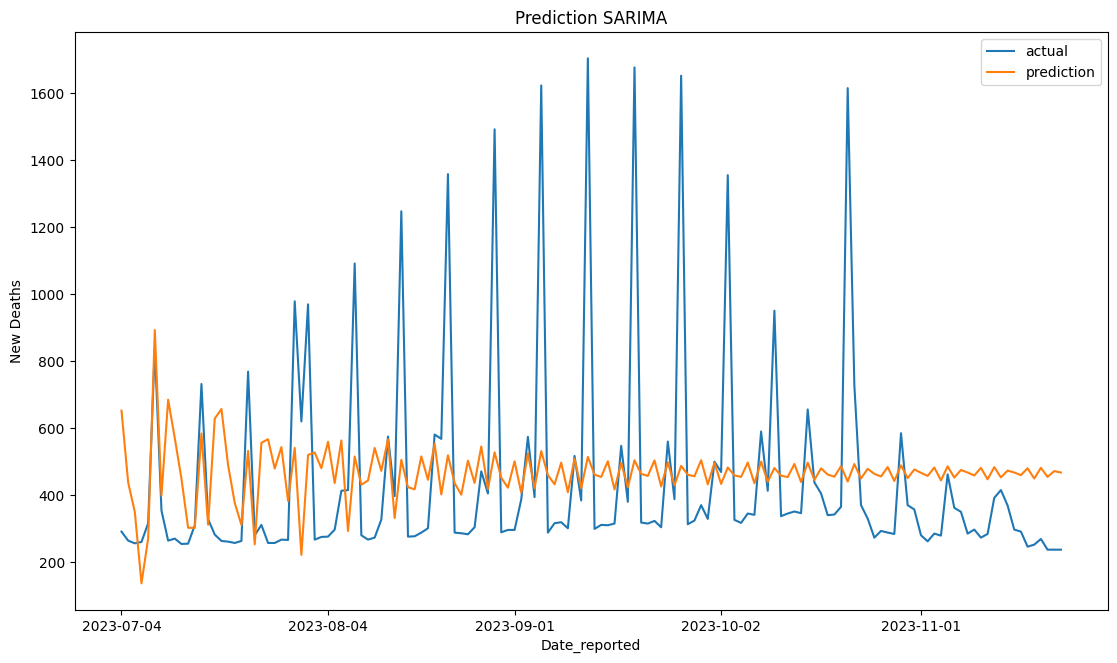

In [14]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels")

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[int(data_length*train_split):], test[target_column].values, label="actual")
ax.plot(dates[int(data_length*train_split):], list(pred), label="prediction")
ax.set_title("Prediction SARIMA")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

RMSE of the result

In [15]:
non_zero = []
import sys
 
for i in pred:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test[target_column])

Evaluation Metrics:
MSE: 100028.15
RMSE: 316.27
MAE: 208.44
MAPE: 47.76
SMAPE: 40.94


In [12]:
store_model(model, "sarima")